# Imports, Defining Functions, etc.

**Team Blue Clusters**

**Here we are checking if ETH is correlated with any of Traditional Macro Data, and of yes, to check how accurate would be ETH Price prediction model based on Macro Data**


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 836 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# imports 

import pandas as pd
import numpy as np 
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import random,os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler 


In [ ]:
# Import Drive API and authenticate.
from google.colab import drive
# Mount your Drive to the Colab VM.
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# building a df of 4 columns: price, returns, marketcap, volume

def build_df(path_to_parquet_file, array_with_our_choices): 

  # reading the big df with all assets
  all_assets = pd.DataFrame()
  all_assets = pd.read_parquet(path_to_parquet_file) 
  
  # resetting index and cleaning column names from bull shit 
  all_assets.reset_index(inplace=True) 
  all_assets.columns = [c.split('.')[-1].replace('_','') for c in all_assets.columns]

  # array with all unqiue symbols from MAIN FILE  
  all_symbols = all_assets["symbol"].unique() 

  # list to store our small dataframes with our chosen assets 
  list_of_df = list()  

# just in case, this is very important --> below is for loop haha 

  for symbol in array_with_our_choices:

    # temp df for slicing main big df
    temp_df = pd.DataFrame() 
    temp_df = all_assets.loc[all_assets['symbol'] == symbol] 

    # small df for processing stuff and storing in our list_of_df 
    small_df = pd.DataFrame() 
    small_df = temp_df[['timeclose', 'close', 'marketcap', 'volume']] 
    small_df = small_df.set_index(['timeclose']) 

    # inserting column for "returns"  
    small_df.insert(1, 'returns', small_df['close'].pct_change()) 
    small_df = small_df.rename(columns={'close' : 'price'}) 

    # renaming columns based on the symbol that we are looping at 
    small_df.columns = [c.replace(c, symbol+'_'+c) for c in small_df.columns]

    # pasting to our list 
    list_of_df.append(small_df) 

  # final dataframe with beatufilly structured chosen assets 
  final_df = pd.DataFrame() 

  # looping thru our chosen assets in our list 
  for df in list_of_df: 
    final_df = final_df.join(df, how='outer')  

  return final_df 

In [ ]:
# building a df of 3 columns: price, marketcap, volume

def build(path_to_parquet_file, array_with_our_choices): 

  # reading the big df with all assets
  all_assets = pd.DataFrame()
  all_assets = pd.read_parquet(path_to_parquet_file) 
  
  # resetting index and cleaning column names from bull shit 
  all_assets.reset_index(inplace=True) 
  all_assets.columns = [c.split('.')[-1].replace('_','') for c in all_assets.columns]

  # array with all unqiue symbols from MAIN FILE  
  all_symbols = all_assets["symbol"].unique() 

  # list to store our small dataframes with our chosen assets 
  list_of_df = list()  

# just in case, this is very important --> below is for loop haha 

  for symbol in array_with_our_choices:

    # temp df for slicing main big df
    temp_df = pd.DataFrame() 
    temp_df = all_assets.loc[all_assets['symbol'] == symbol] 

    # small df for processing stuff and storing in our list_of_df 
    small_df = pd.DataFrame() 
    small_df = temp_df[['timeclose', 'close', 'marketcap', 'volume']] 
    small_df = small_df.set_index(['timeclose']) 

    # inserting column for "returns"  
    # small_df.insert(1, 'returns', small_df['close'].pct_change()) 
    small_df = small_df.rename(columns={'close' : 'price'}) 

    # renaming columns based on the symbol that we are looping at 
    small_df.columns = [c.replace(c, symbol+'_'+c) for c in small_df.columns]

    # pasting to our list 
    list_of_df.append(small_df) 

  # final dataframe with beatufilly structured chosen assets 
  final_df = pd.DataFrame() 

  # looping thru our chosen assets in our list 
  for df in list_of_df: 
    final_df = final_df.join(df, how='outer')  

  return final_df 

# Correlation of ETH with traditional Market Data

In [ ]:
import random,os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset
from collections import OrderedDict


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_absolute_error

In [ ]:
# eth = pd.read_csv('/content/gdrive/My Drive/ML540 - Blue Clusters/datafiles/ETH-USD.csv') 
path_to_file = '/content/gdrive/My Drive/ML540 - Blue Clusters/datafiles/hourly.parquet.gzip' 
eth_choice = ['ETH']


In [ ]:
eth = build(path_to_file, eth_choice) 

eth

,ETH_price,ETH_marketcap,ETH_volume
timeclose,,,
2019-01-01T20:59:59.999Z,140.346549,1.461575e+10,NaN
2019-01-01T21:59:59.999Z,139.695956,1.454810e+10,NaN
2019-01-01T22:59:59.999Z,139.968871,1.457664e+10,NaN
2019-01-01T23:59:59.999Z,140.819413,1.466532e+10,NaN
2019-01-02T00:59:59.999Z,141.995471,1.478792e+10,NaN
...,...,...,...
2022-10-10T15:59:59.999Z,1309.793999,1.607582e+11,7.986097e+09
2022-10-10T16:59:59.999Z,1302.063136,1.598109e+11,8.164318e+09
2022-10-10T17:59:59.999Z,1312.236572,1.610596e+11,8.503369e+09


In [ ]:
eth = eth.reset_index()
eth.rename(columns={'timeclose' : 'Timestamp'}, inplace=True) 


In [ ]:
eth['Timestamp'] = eth['Timestamp'].astype('datetime64[ns]') 

eth

,Timestamp,ETH_price,ETH_marketcap,ETH_volume
0,2019-01-01 20:59:59.999,140.346549,1.461575e+10,NaN
1,2019-01-01 21:59:59.999,139.695956,1.454810e+10,NaN
2,2019-01-01 22:59:59.999,139.968871,1.457664e+10,NaN
3,2019-01-01 23:59:59.999,140.819413,1.466532e+10,NaN
4,2019-01-02 00:59:59.999,141.995471,1.478792e+10,NaN
...,...,...,...,...
31671,2022-10-10 15:59:59.999,1309.793999,1.607582e+11,7.986097e+09
31672,2022-10-10 16:59:59.999,1302.063136,1.598109e+11,8.164318e+09
31673,2022-10-10 17:59:59.999,1312.236572,1.610596e+11,8.503369e+09
31674,2022-10-10 18:59:59.999,1307.703914,1.605048e+11,8.612745e+09


In [ ]:
eth.set_index('Timestamp', inplace = True) 
eth

,ETH_price,ETH_marketcap,ETH_volume
Timestamp,,,
2019-01-01 20:59:59.999,140.346549,1.461575e+10,NaN
2019-01-01 21:59:59.999,139.695956,1.454810e+10,NaN
2019-01-01 22:59:59.999,139.968871,1.457664e+10,NaN
2019-01-01 23:59:59.999,140.819413,1.466532e+10,NaN
2019-01-02 00:59:59.999,141.995471,1.478792e+10,NaN
...,...,...,...
2022-10-10 15:59:59.999,1309.793999,1.607582e+11,7.986097e+09
2022-10-10 16:59:59.999,1302.063136,1.598109e+11,8.164318e+09
2022-10-10 17:59:59.999,1312.236572,1.610596e+11,8.503369e+09


In [ ]:
eth_try = eth.copy()
eth_try.reset_index(inplace=True)
eth_try['Timestamp'] = pd.to_datetime(eth_try['Timestamp'], unit='s') 

eth_try

# df['date'] = pd.to_datetime(df['date'],unit='s') 

,Timestamp,ETH_price,ETH_marketcap,ETH_volume
0,2019-01-01 20:59:59.999,140.346549,1.461575e+10,NaN
1,2019-01-01 21:59:59.999,139.695956,1.454810e+10,NaN
2,2019-01-01 22:59:59.999,139.968871,1.457664e+10,NaN
3,2019-01-01 23:59:59.999,140.819413,1.466532e+10,NaN
4,2019-01-02 00:59:59.999,141.995471,1.478792e+10,NaN
...,...,...,...,...
31671,2022-10-10 15:59:59.999,1309.793999,1.607582e+11,7.986097e+09
31672,2022-10-10 16:59:59.999,1302.063136,1.598109e+11,8.164318e+09
31673,2022-10-10 17:59:59.999,1312.236572,1.610596e+11,8.503369e+09
31674,2022-10-10 18:59:59.999,1307.703914,1.605048e+11,8.612745e+09


In [ ]:
eth_daily = eth.resample('D').mean() 
eth_daily.index.rename('Date', inplace=True) 
eth_daily 

# df.index.rename('Index', inplace=True)


,ETH_price,ETH_marketcap,ETH_volume
Date,,,
2019-01-01,140.207697,1.460145e+10,NaN
2019-01-02,148.377302,1.545392e+10,NaN
2019-01-03,151.203785,1.575107e+10,NaN
2019-01-04,152.274441,1.586534e+10,NaN
2019-01-05,158.057525,1.647068e+10,NaN
...,...,...,...
2022-10-06,1365.213593,1.674795e+11,1.161820e+10
2022-10-07,1343.354488,1.648171e+11,1.063843e+10
2022-10-08,1326.847058,1.628108e+11,7.856943e+09


In [ ]:
market_data = pd.read_csv('/content/gdrive/My Drive/ML540 - Blue Clusters/datafiles/market_data_ffill.csv', index_col=0) 
market_data = market_data.reset_index()
market_data.rename(columns={'index': 'Date'}, inplace=True)
market_data['Date'] = market_data['Date'].astype('datetime64[ns]') 
market_data.set_index('Date') 

market_data 

,Date,Inflation_CPI,Inflation_PCE,VIX,10yr_bond,Fed_funds_rate,2yr_bond,Inflations_expectations,Inflation_surprises,Economic_surprises,Umichigan_survey,ISM_Manufacturing,Hourly_earnings,MS_Market_Sentiment,SPX,NASDAQ
0,2000-01-03,0.2,0.2,24.21,6.59,5.50,6.38,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1455.22,4131.15
1,2000-01-04,0.2,0.2,27.01,6.50,5.50,6.30,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1399.42,3901.69
2,2000-01-05,0.2,0.2,26.41,6.59,5.50,6.36,NaN,-6.88,0.09,105.4,57.8,NaN,NaN,1402.11,3877.54
3,2000-01-06,0.2,0.2,25.73,6.52,5.50,6.30,NaN,-6.88,0.00,105.4,57.8,NaN,NaN,1403.45,3727.13
4,2000-01-07,0.2,0.2,21.72,6.52,5.50,6.31,NaN,-6.88,0.08,105.4,57.8,NaN,NaN,1441.47,3882.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8299,2022-09-23,0.1,-0.1,29.92,3.68,3.25,4.20,5.75,26.53,-0.16,58.2,52.8,5.2,-0.75,3693.23,10867.93
8300,2022-09-24,0.1,-0.1,29.92,3.68,3.25,4.20,5.75,26.53,-0.16,58.2,52.8,5.2,-0.75,3693.23,10867.93
8301,2022-09-25,0.1,-0.1,29.92,3.68,3.25,4.20,5.75,26.53,-0.16,58.2,52.8,5.2,-0.75,3693.23,10867.93
8302,2022-09-26,0.1,-0.1,32.26,3.92,3.25,4.34,5.75,26.53,-0.16,58.2,52.8,5.2,-0.86,3655.04,10802.92


In [ ]:
md_hourly = market_data.set_index("Date").resample("H").ffill().reset_index().rename(
    {"Date": "Timestamp"}, axis=1
) 

md_hourly 

# df.set_index("Date").resample("H").ffill().reset_index().rename(
#     {"Date": "Timestamp"}, axis=1
# ) 

,Timestamp,Inflation_CPI,Inflation_PCE,VIX,10yr_bond,Fed_funds_rate,2yr_bond,Inflations_expectations,Inflation_surprises,Economic_surprises,Umichigan_survey,ISM_Manufacturing,Hourly_earnings,MS_Market_Sentiment,SPX,NASDAQ
0,2000-01-03 00:00:00,0.2,0.2,24.21,6.59,5.50,6.38,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1455.22,4131.15
1,2000-01-03 01:00:00,0.2,0.2,24.21,6.59,5.50,6.38,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1455.22,4131.15
2,2000-01-03 02:00:00,0.2,0.2,24.21,6.59,5.50,6.38,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1455.22,4131.15
3,2000-01-03 03:00:00,0.2,0.2,24.21,6.59,5.50,6.38,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1455.22,4131.15
4,2000-01-03 04:00:00,0.2,0.2,24.21,6.59,5.50,6.38,NaN,-6.88,0.05,105.4,57.8,NaN,NaN,1455.22,4131.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199268,2022-09-26 20:00:00,0.1,-0.1,32.26,3.92,3.25,4.34,5.75,26.53,-0.16,58.2,52.8,5.2,-0.86,3655.04,10802.92
199269,2022-09-26 21:00:00,0.1,-0.1,32.26,3.92,3.25,4.34,5.75,26.53,-0.16,58.2,52.8,5.2,-0.86,3655.04,10802.92
199270,2022-09-26 22:00:00,0.1,-0.1,32.26,3.92,3.25,4.34,5.75,26.53,-0.16,58.2,52.8,5.2,-0.86,3655.04,10802.92
199271,2022-09-26 23:00:00,0.1,-0.1,32.26,3.92,3.25,4.34,5.75,26.53,-0.16,58.2,52.8,5.2,-0.86,3655.04,10802.92


In [ ]:
fin_df = eth_daily.copy()
fin_df 


,ETH_price,ETH_marketcap,ETH_volume
Date,,,
2019-01-01,140.207697,1.460145e+10,NaN
2019-01-02,148.377302,1.545392e+10,NaN
2019-01-03,151.203785,1.575107e+10,NaN
2019-01-04,152.274441,1.586534e+10,NaN
2019-01-05,158.057525,1.647068e+10,NaN
...,...,...,...
2022-10-06,1365.213593,1.674795e+11,1.161820e+10
2022-10-07,1343.354488,1.648171e+11,1.063843e+10
2022-10-08,1326.847058,1.628108e+11,7.856943e+09


In [ ]:
fin_df.reset_index()
fin_df = fin_df.merge(market_data, on='Date')
fin_df

,Date,ETH_price,ETH_marketcap,ETH_volume,Inflation_CPI,Inflation_PCE,VIX,10yr_bond,Fed_funds_rate,2yr_bond,Inflations_expectations,Inflation_surprises,Economic_surprises,Umichigan_survey,ISM_Manufacturing,Hourly_earnings,MS_Market_Sentiment,SPX,NASDAQ
0,2019-01-01,140.207697,1.460145e+10,NaN,0.0,0.0,25.42,2.68,2.50,2.49,3.00,-6.91,-0.25,98.3,54.9,3.4,-1.12,2506.85,6635.28
1,2019-01-02,148.377302,1.545392e+10,NaN,0.0,0.0,23.22,2.62,2.50,2.47,3.00,-6.91,-0.25,98.3,54.9,3.4,-1.11,2510.03,6665.94
2,2019-01-03,151.203785,1.575107e+10,NaN,0.0,0.0,25.45,2.55,2.50,2.38,3.00,-6.91,-0.25,98.3,54.9,3.4,-1.11,2447.89,6463.50
3,2019-01-04,152.274441,1.586534e+10,NaN,0.0,0.0,21.38,2.67,2.50,2.49,3.00,-6.91,-0.19,98.3,54.9,3.4,-1.09,2531.94,6738.86
4,2019-01-05,158.057525,1.647068e+10,NaN,0.0,0.0,21.38,2.67,2.50,2.49,3.00,-6.91,-0.19,98.3,54.9,3.4,-1.09,2531.94,6738.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,2022-09-23,1313.067899,1.608382e+11,1.864730e+10,0.1,-0.1,29.92,3.68,3.25,4.20,5.75,26.53,-0.16,58.2,52.8,5.2,-0.75,3693.23,10867.93
1362,2022-09-24,1329.676036,1.628916e+11,1.593777e+10,0.1,-0.1,29.92,3.68,3.25,4.20,5.75,26.53,-0.16,58.2,52.8,5.2,-0.75,3693.23,10867.93
1363,2022-09-25,1313.842738,1.609707e+11,1.114178e+10,0.1,-0.1,29.92,3.68,3.25,4.20,5.75,26.53,-0.16,58.2,52.8,5.2,-0.75,3693.23,10867.93
1364,2022-09-26,1313.277949,1.609203e+11,1.478508e+10,0.1,-0.1,32.26,3.92,3.25,4.34,5.75,26.53,-0.16,58.2,52.8,5.2,-0.86,3655.04,10802.92


In [ ]:
fin_df.set_index('Date', inplace=True)

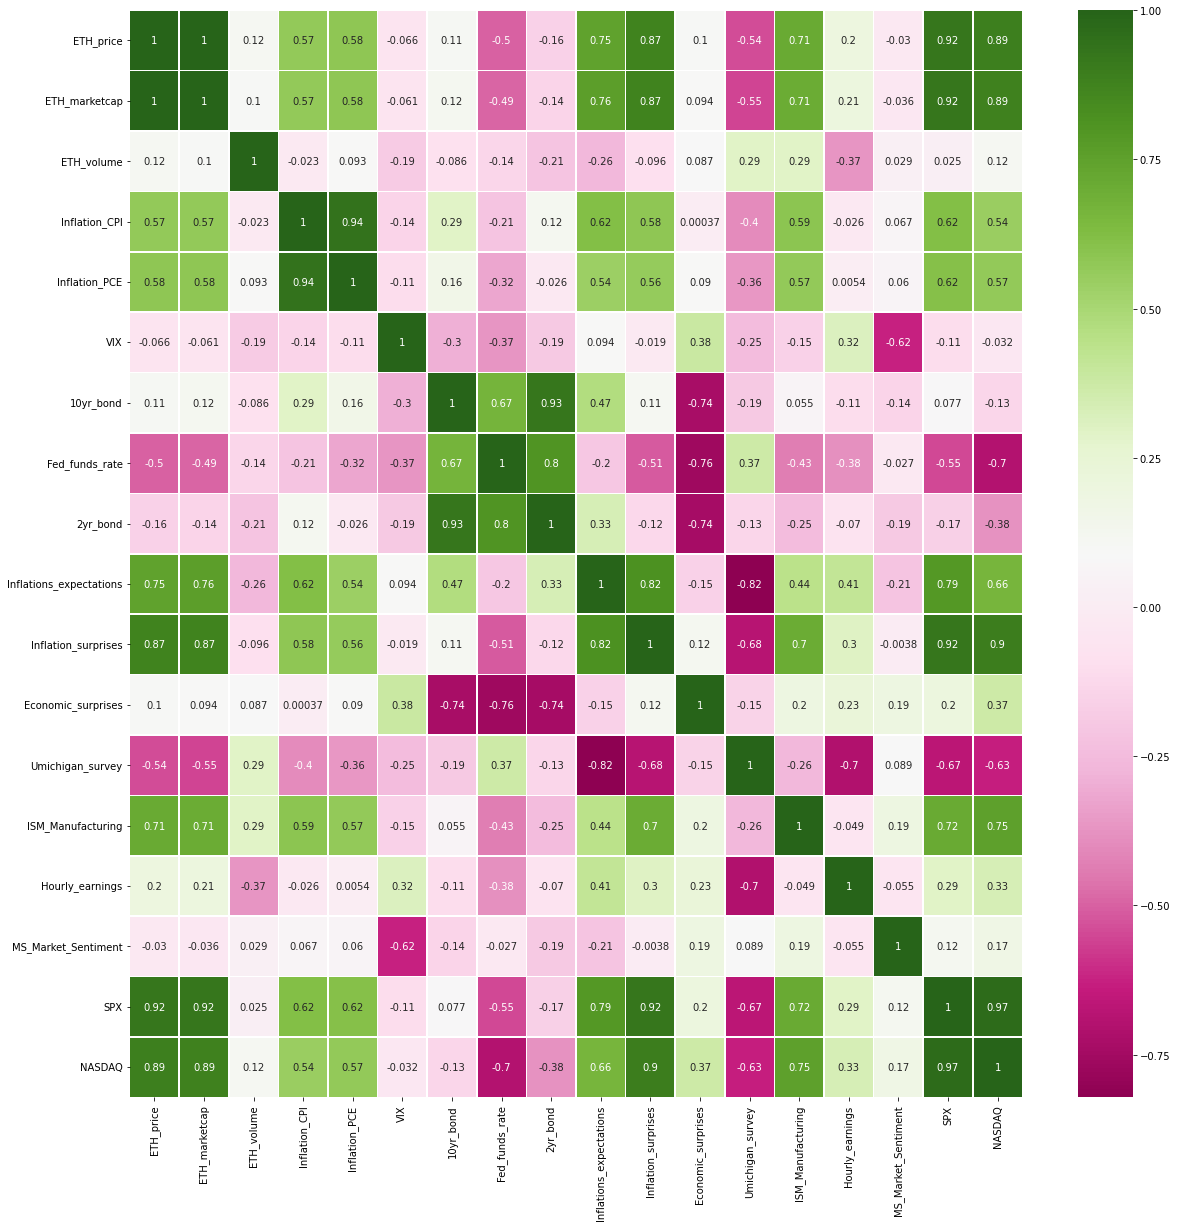

In [ ]:
corr2 = fin_df.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corr2, cmap="PiYG", linewidths=.5, annot=True) 

In [ ]:
# pri = fin_df[['ETH_price','ETH_marketcap']].values
# display(pri) 

In [ ]:
eth_lr = fin_df.copy()

eth_lr = eth_lr[['ETH_price', 'ETH_marketcap', 'Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ']]
eth_lr.dropna(inplace=True)

eth_lr 


,ETH_price,ETH_marketcap,Inflations_expectations,Inflation_surprises,ISM_Manufacturing,SPX,NASDAQ
Date,,,,,,,
2019-01-01,140.207697,1.460145e+10,3.00,-6.91,54.9,2506.85,6635.28
2019-01-02,148.377302,1.545392e+10,3.00,-6.91,54.9,2510.03,6665.94
2019-01-03,151.203785,1.575107e+10,3.00,-6.91,54.9,2447.89,6463.50
2019-01-04,152.274441,1.586534e+10,3.00,-6.91,54.9,2531.94,6738.86
2019-01-05,158.057525,1.647068e+10,3.00,-6.91,54.9,2531.94,6738.86
...,...,...,...,...,...,...,...
2022-09-23,1313.067899,1.608382e+11,5.75,26.53,52.8,3693.23,10867.93
2022-09-24,1329.676036,1.628916e+11,5.75,26.53,52.8,3693.23,10867.93
2022-09-25,1313.842738,1.609707e+11,5.75,26.53,52.8,3693.23,10867.93


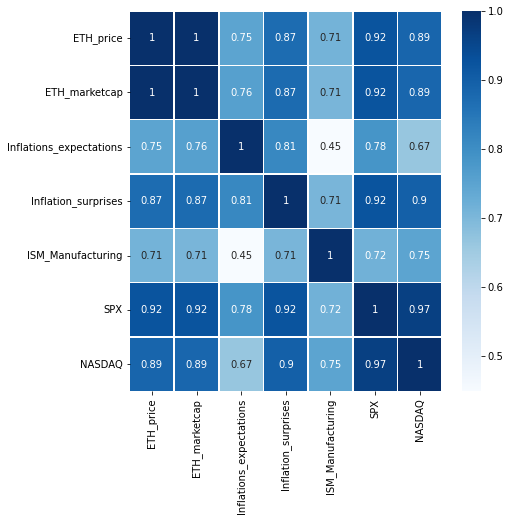

In [ ]:
corr_3 = eth_lr.corr()
plt.figure(figsize = (7, 7))
sns.heatmap(corr_3, cmap="Blues",  linewidths=.5, annot=True) 

In [ ]:
# split function def 

def splitData(df, train_percent): 
  min_date = df.index.min()
  max_date = df.index.max()
  time_between = max_date - min_date
  train_cutoff = min_date + train_percent*time_between
  train_cutoff
  train_df = df[df.index <= train_cutoff]
  test_df = df[df.index > train_cutoff]
  return train_df,test_df

In [ ]:
# don't know what that stuff is - copied from main file 
# df['ds'] = df.index.tz_convert(None)
# df['y'] = df['ETH_price']
# df['add1'] = df['ETH_marketcap'].shift(1)
# df.dropna(subset=['add1'],inplace=True)

train_df, test_df=splitData(eth_lr,0.9)
display(eth_lr.head())

print("Train:", train_df.index.min(), train_df.index.max()) 
print("Test:", test_df.index.min(), test_df.index.max()) 


,ETH_price,ETH_marketcap,Inflations_expectations,Inflation_surprises,ISM_Manufacturing,SPX,NASDAQ
Date,,,,,,,
2019-01-01,140.207697,1.460145e+10,3.0,-6.91,54.9,2506.85,6635.28
2019-01-02,148.377302,1.545392e+10,3.0,-6.91,54.9,2510.03,6665.94
2019-01-03,151.203785,1.575107e+10,3.0,-6.91,54.9,2447.89,6463.50
2019-01-04,152.274441,1.586534e+10,3.0,-6.91,54.9,2531.94,6738.86
2019-01-05,158.057525,1.647068e+10,3.0,-6.91,54.9,2531.94,6738.86


Train: 2019-01-01 00:00:00 2022-05-13 00:00:00
Test: 2022-05-14 00:00:00 2022-09-27 00:00:00


In [ ]:
#  Linear Regression based on ETH and SPX 
# Spoiler - it didn't work well 

from sklearn.linear_model import LinearRegression

def autocorr_model(eth_df):

    ### BEGIN SOLUTION ###

    # Add column containing the value at t-1
    eth_df['PreETH_price'] = eth_df['ETH_price'].shift() #Add new column containing count at days_lag
    eth_df['PreETH_marketcap'] = eth_df['ETH_marketcap'].shift() #Add new column containing MCap at days_lag

    eth_df = eth_df.iloc[1:] 

    # Create a single-variable linear regression
    # ETH_price	Inflation_surprises	Inflation_surprises	ISM_Manufacturing	SPX	NASDAQ

    model = LinearRegression()
    # model.fit(X=eth_df[['SPX']].values.reshape(-1, 1), 
    #           y=eth_df['ETH_price'])
    model.fit(X=eth_df[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ', 'PreETH_price', 'PreETH_marketcap']], 
              y=eth_df['ETH_price'])

    # Get in-sample predictions for the days in the month
    preds = model.predict(eth_df[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ', 'PreETH_price', 'PreETH_marketcap']])
    # preds = model.predict(eth_df[['SPX']].values.reshape(-1, 1))

    
    resids = eth_df['ETH_price'] - preds


    return model, preds,  eth_df['ETH_price']

The training model is: y = 12.135x + -138.565
The simple linear model has R^2=0.997 and MAE=37.66


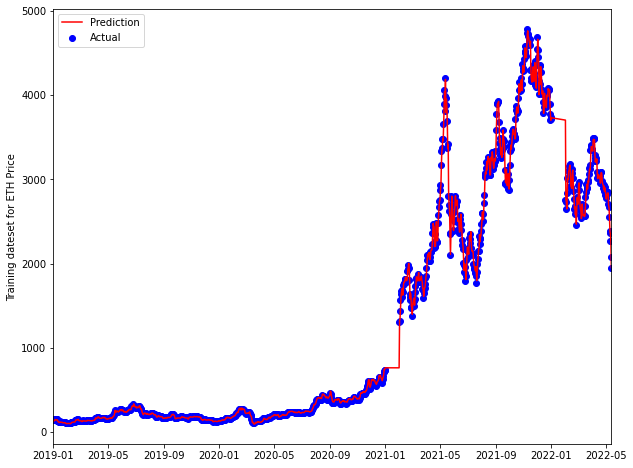

In [ ]:
# SIMPLE LINEAR REGRESSION MODEL 

overall=dict()

regressionData = train_df.copy()

model, preds, y_true = autocorr_model(regressionData)

# Display the model
print('The training model is: y = {:.3f}x + {:.3f}'.format(model.coef_[0], model.intercept_))
mse = mean_absolute_error(y_true, preds)
r2 =  r2_score(y_true,preds)

# Calculate and display the model performance statistics
overall['linear_regression_autocorr']={'train': {'mae':mse,"r2":r2}}
print('The simple linear model has R^2={:.3f} and MAE={:.2f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,8)) 
plt.scatter(x=regressionData.index, y=regressionData['ETH_price'], color='blue', label='Actual') 
plt.plot(regressionData.index[1:], preds, color='red', label='Prediction') 
plt.legend()
plt.xlim((regressionData.index[:].min(),regressionData.index[:].max())) 
plt.ylabel('Training dateset for ETH Price') 
plt.show() 

The simple linear model has R^2=0.954,MAE=49.32


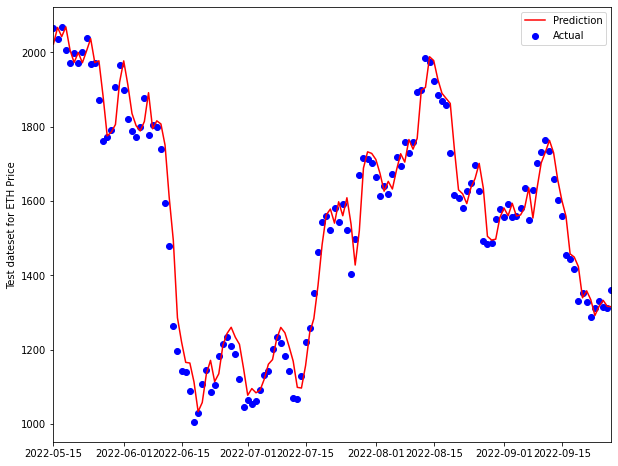

In [ ]:
# test df 

regressionData = test_df.copy()
regressionData['PreETH_price'] = regressionData['ETH_price'].shift()
regressionData['PreETH_marketcap'] = regressionData['ETH_marketcap'].shift()
regressionData = regressionData.iloc[1:]
preds = model.predict(regressionData[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ','PreETH_price', 'PreETH_marketcap']])

r2_auto = r2_score(regressionData['ETH_price'], preds)
mae_auto = mean_absolute_error(regressionData['ETH_price'], preds)
print('The simple linear model has R^2={:.3f},MAE={:.2f}'.format(r2_auto, mae_auto))

overall['linear_regression_autocorr']['test']={'mae':mae_auto,"r2":r2_auto} 

# Plot the data and the predictions
plt.figure(figsize=(10, 8))
plt.scatter(x=regressionData.index, y=regressionData['ETH_price'], color='blue', label='Actual')
plt.plot(regressionData.index, preds, color='red', label='Prediction') 

plt.legend()
plt.xlim((regressionData.index[:].min(), regressionData.index[:].max()))
plt.ylabel('Test dateset for ETH Price')
plt.show() 

# XGBoost Model

In [ ]:
# import for XGB
from xgboost import XGBRegressor
 

In [ ]:
# XGBoost model 

def autocorr_model_xgb(eth_df):

    ### BEGIN SOLUTION ###

    # Add column containing the value at t-1
    eth_df['PreETH_price'] = eth_df['ETH_price'].shift() #Add new column containing count at days_lag
    eth_df['PreETH_marketcap'] = eth_df['ETH_marketcap'].shift() #Add new column containing MCap at days_lag

    eth_df = eth_df.iloc[1:]

    # Create a single-variable linear regression
    # ETH_price	Inflation_surprises	Inflation_surprises	ISM_Manufacturing	SPX	NASDAQ

    model = XGBRegressor()
    # model.fit(X=eth_df[['SPX']].values.reshape(-1, 1),
    #           y=eth_df['ETH_price'])
    model.fit(X=eth_df[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ', 'PreETH_price', 'PreETH_marketcap']],
              y=eth_df['ETH_price'])

    # Get in-sample predictions for the days in the month
    preds = model.predict(eth_df[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ', 'PreETH_price', 'PreETH_marketcap']])
    # preds = model.predict(eth_df[['SPX']].values.reshape(-1, 1))



    return model, preds,  eth_df['ETH_price'] 

[19:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The XGB model has R^2=0.999 and MAE=25.22


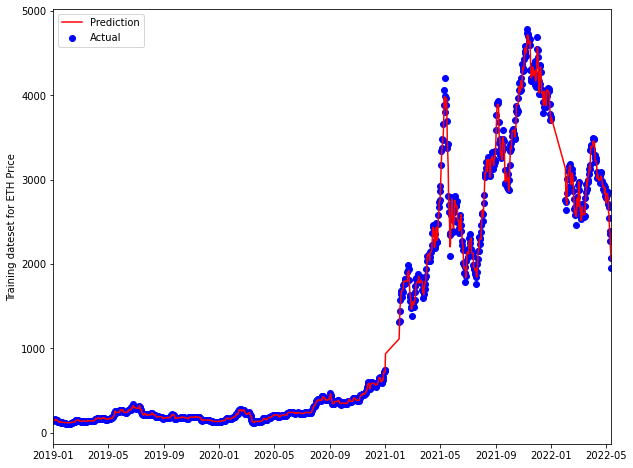

In [ ]:
# XGBoost model 

regressionData = train_df.copy()

model, preds, y_true = autocorr_model_xgb(regressionData)

# Display the model
mse = mean_absolute_error(y_true, preds)
r2 =  r2_score(y_true,preds)

# Calculate and display the model performance statistics
overall['linear_regression_autocorr']={'train': {'mae':mse,"r2":r2}}
print('The XGB model has R^2={:.3f} and MAE={:.2f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,8))
plt.scatter(x=regressionData.index, y=regressionData['ETH_price'], color='blue', label='Actual')
plt.plot(regressionData.index[1:], preds, color='red', label='Prediction')
plt.legend()
plt.xlim((regressionData.index[:].min(),regressionData.index[:].max()))
plt.ylabel('Training dateset for ETH Price')
plt.show()

The XGB model has R^2=0.886,MAE=80.80


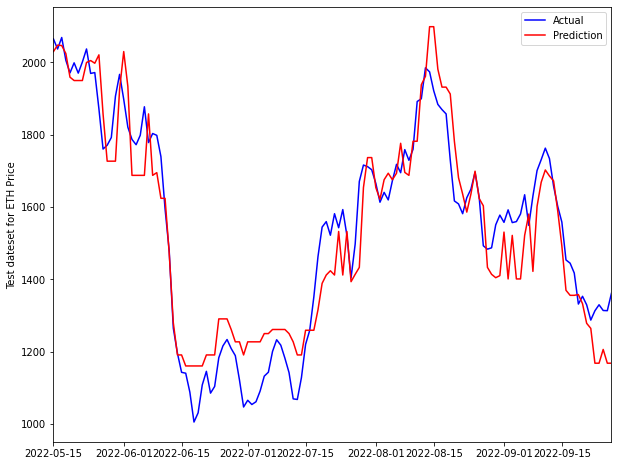

In [ ]:
# test XGB

regressionData = test_df.copy()
regressionData['PreETH_price'] = regressionData['ETH_price'].shift()
regressionData['PreETH_marketcap'] = regressionData['ETH_marketcap'].shift()
regressionData = regressionData.iloc[1:]
preds = model.predict(regressionData[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ','PreETH_price', 'PreETH_marketcap']])

r2_auto = r2_score(regressionData['ETH_price'], preds)
mae_auto = mean_absolute_error(regressionData['ETH_price'], preds)
print('The XGB model has R^2={:.3f},MAE={:.2f}'.format(r2_auto, mae_auto))

overall['linear_regression_autocorr']['test']={'mae':mae_auto,"r2":r2_auto}

# Plot the data and the predictions
plt.figure(figsize=(10, 8))
# plt.scatter(x=regressionData.index, y=regressionData['ETH_price'], color='blue', label='Actual') 
plt.plot(regressionData.index, regressionData['ETH_price'], color='blue', label='Actual')
plt.plot(regressionData.index, preds, color='red', label='Prediction')

plt.legend()
plt.xlim((regressionData.index[:].min(), regressionData.index[:].max()))
plt.ylabel('Test dateset for ETH Price')
plt.show()

# Trying with only Market Data + ETH Price

In [ ]:
#  Linear Regression based on ETH and SPX 
# Spoiler - it didn't work well 

from sklearn.linear_model import LinearRegression 

def autocorr_model_md(eth_df):

    ### BEGIN SOLUTION ###

    # Add column containing the value at t-1
    # eth_df['PreETH_price'] = eth_df['ETH_price'].shift() #Add new column containing count at days_lag
    # eth_df['PreETH_marketcap'] = eth_df['ETH_marketcap'].shift() #Add new column containing MCap at days_lag

    # eth_df = eth_df.iloc[1:] 

    # Create a single-variable linear regression
    # ETH_price	Inflation_surprises	Inflation_surprises	ISM_Manufacturing	SPX	NASDAQ

    model = LinearRegression()
    # model.fit(X=eth_df[['SPX']].values.reshape(-1, 1), 
    #           y=eth_df['ETH_price'])
    model.fit(X=eth_df[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ']], 
              y=eth_df['ETH_price'])

    # Get in-sample predictions for the days in the month
    preds = model.predict(eth_df[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ']])
    # preds = model.predict(eth_df[['SPX']].values.reshape(-1, 1))

    
    resids = eth_df['ETH_price'] - preds


    return model, preds,  eth_df['ETH_price']


The training model is: y = 355.601x + -5846.791
The simple linear model "MD" has R^2=0.904 and MAE=322.63


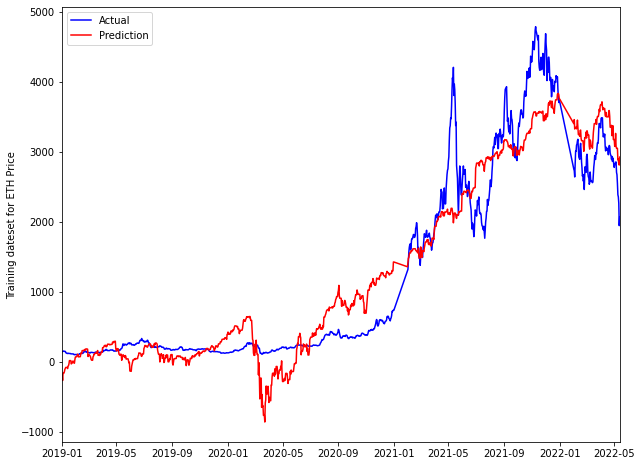

In [ ]:
# SIMPLE LINEAR REGRESSION MODEL 

overall=dict()

regressionData = train_df.copy()

model, preds, y_true = autocorr_model_md(regressionData)

# Display the model
print('The training model is: y = {:.3f}x + {:.3f}'.format(model.coef_[0], model.intercept_))
mse = mean_absolute_error(y_true, preds)
r2 =  r2_score(y_true,preds)

# Calculate and display the model performance statistics
overall['linear_regression_autocorr']={'train': {'mae':mse,"r2":r2}}
print('The simple linear model "MD" has R^2={:.3f} and MAE={:.2f}'.format(r2,mse))

# Plot the data and the predictions
plt.figure(figsize=(10,8)) 
# plt.scatter(x=regressionData.index, y=regressionData['ETH_price'], color='blue', label='Actual') 
plt.plot(regressionData.index[:], regressionData['ETH_price'], color='blue', label='Actual') 
plt.plot(regressionData.index[:], preds, color='red', label='Prediction') 
plt.legend()
plt.xlim((regressionData.index[:].min(),regressionData.index[:].max())) 
plt.ylabel('Training dateset for ETH Price') 
plt.show() 


The simple linear model "MD" has R^2=-18.596,MAE=1274.54


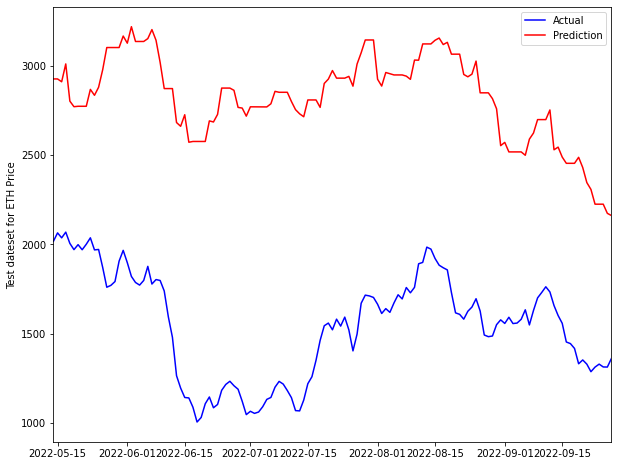

In [ ]:
# test df 

regressionData = test_df.copy()

# regressionData['PreETH_price'] = regressionData['ETH_price'].shift()
# regressionData['PreETH_marketcap'] = regressionData['ETH_marketcap'].shift()
# regressionData = regressionData.iloc[1:]

preds = model.predict(regressionData[['Inflations_expectations', 'Inflation_surprises', 'ISM_Manufacturing', 'SPX', 'NASDAQ']])

#   .values.reshape(-1, 1)

r2_auto = r2_score(regressionData['ETH_price'], preds) 
mae_auto = mean_absolute_error(regressionData['ETH_price'], preds) 
print('The simple linear model "MD" has R^2={:.3f},MAE={:.2f}'.format(r2_auto, mae_auto))

overall['linear_regression_autocorr']['test']={'mae':mae_auto,"r2":r2_auto} 

# Plot the data and the predictions
plt.figure(figsize=(10, 8))
# plt.scatter(x=regressionData.index, y=regressionData['ETH_price'], color='blue', label='Actual')
plt.plot(regressionData.index, regressionData['ETH_price'], color='blue', label='Actual') 
plt.plot(regressionData.index, preds, color='red', label='Prediction') 

plt.legend()
plt.xlim((regressionData.index[:].min(), regressionData.index[:].max()))
plt.ylabel('Test dateset for ETH Price')
plt.show() 
